In [3]:
!pip -q install kaggle tensorflow scikit-learn

import tensorflow as tf, numpy as np, pandas as pd, matplotlib.pyplot as plt, os, pathlib
print("TensorFlow:", tf.__version__)


TensorFlow: 2.19.0


In [4]:
from google.colab import files
files.upload()  # choose kaggle.json you downloaded from Kaggle


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yehiasherif","key":"65e2cad467900d4f0c642ffb6bad9648"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [6]:
!mkdir -p /content/data
!kaggle datasets download -d gpiosenka/sports-classification -p /content/data
!unzip -q /content/data/sports-classification.zip -d /content/data
!ls -R /content/data | head -n 60


Dataset URL: https://www.kaggle.com/datasets/gpiosenka/sports-classification
License(s): CC0-1.0
 91% 387M/424M [00:05<00:00, 65.8MB/s]
100% 424M/424M [00:05<00:00, 80.0MB/s]
/content/data:
EfficientNetB0-100-(224 X 224)- 98.40.h5
sports-classification.zip
sports.csv
test
train
valid

/content/data/test:
air hockey
ampute football
archery
arm wrestling
axe throwing
balance beam
barell racing
baseball
basketball
baton twirling
bike polo
billiards
bmx
bobsled
bowling
boxing
bull riding
bungee jumping
canoe slamon
cheerleading
chuckwagon racing
cricket
croquet
curling
disc golf
fencing
field hockey
figure skating men
figure skating pairs
figure skating women
fly fishing
football
formula 1 racing
frisbee
gaga
giant slalom
golf
hammer throw
hang gliding
harness racing
high jump
hockey
horse jumping
horse racing
horseshoe pitching
hurdles
hydroplane racing
ice climbing
ice yachting
jai alai
javelin


In [7]:
img_size   = (128, 128)
batch_size = 32
seed = 42

train_dir = "/content/data/train"
val_dir   = "/content/data/valid"
test_dir  = "/content/data/test"

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=batch_size, shuffle=True, seed=seed
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, image_size=img_size, batch_size=batch_size, shuffle=False
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=batch_size, shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", len(class_names))
print(class_names[:10], "...")


Found 13492 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.
Classes: 100
['air hockey', 'ampute football', 'archery', 'arm wrestling', 'axe throwing', 'balance beam', 'barell racing', 'baseball', 'basketball', 'baton twirling'] ...


In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000, seed=seed).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)


Batch: (32, 128, 128, 3) Labels: (32,)


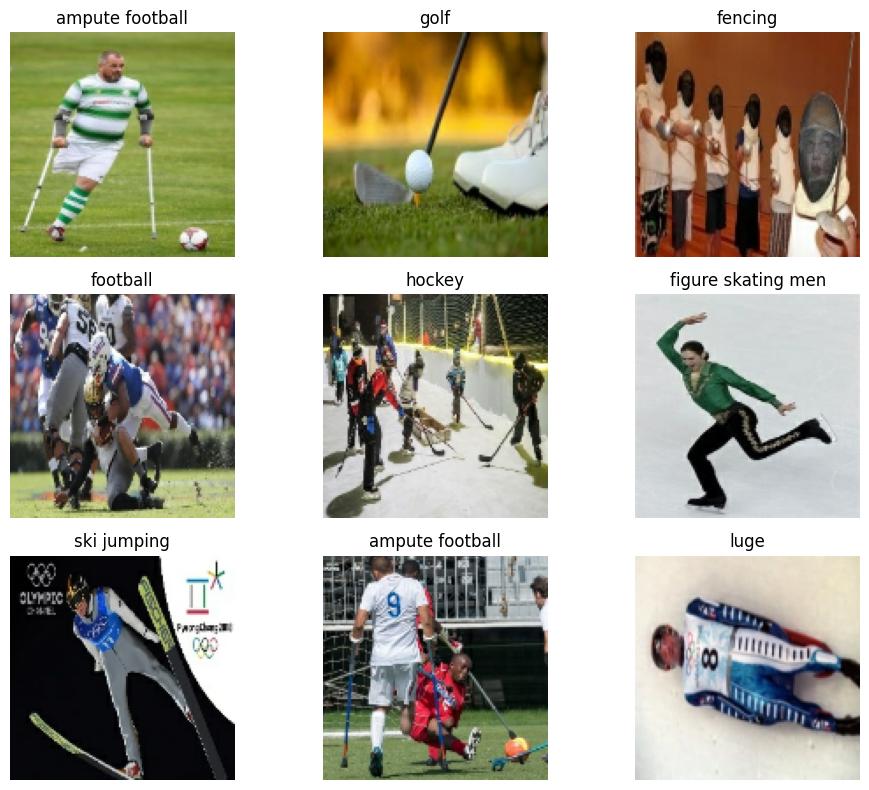

In [9]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_ds))
print("Batch:", images.shape, "Labels:", labels.shape)

plt.figure(figsize=(10,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[int(labels[i])][:20])
    plt.axis("off")
plt.tight_layout()
plt.show()


In [10]:
from tensorflow.keras import layers, models

data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
])

def make_cnn_v1(input_shape=(128,128,3), num_classes=100, dropout=0.3):
    inputs = layers.Input(shape=input_shape)
    x = data_augment(inputs)
    x = layers.Rescaling(1./255)(x)

    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.MaxPool2D()(x)

    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPool2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

model_v1 = make_cnn_v1((128,128,3), num_classes= len(class_names), dropout=0.3)
model_v1.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
model_v1.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,388,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,421,028 (32.12 MB)

 Trainable params: 8,421,028 (32.12 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
ckpt_path = "best_v1.keras"
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True)
]

history_v1 = model_v1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 381s 897ms/step - accuracy: 0.0225 - loss: 4.5548 - val_accuracy: 0.0960 - val_loss: 3.8867
Epoch 2/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 379s 891ms/step - accuracy: 0.0920 - loss: 3.8817 - val_accuracy: 0.2300 - val_loss: 3.3566
Epoch 3/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 371s 879ms/step - accuracy: 0.1364 - loss: 3.5331 - val_accuracy: 0.2100 - val_loss: 3.1725
Epoch 4/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 367s 869ms/step - accuracy: 0.1674 - loss: 3.3627 - val_accuracy: 0.2820 - val_loss: 2.9730
Epoch 5/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 369s 875ms/step - accuracy: 0.1848 - loss: 3.2421 - val_accuracy: 0.3240 - val_loss: 2.7710
Epoch 6/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 371s 879ms/step - accuracy: 0.2079 - loss: 3.1330 - val_accuracy: 0.2820 - val_loss: 2.9037
Epoch 7/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 369s 874ms/step - accuracy: 0.2219 - loss: 3.0464 - val_accuracy: 0.3440 - val_loss: 2.6444
Epoch 8/20
422/422 ━━━━━━━━━━━━━━━━━━━━ 368s 871ms/step - accuracy: 0.2316 -

KeyboardInterrupt: 

Test accuracy: 0.344
                       precision    recall  f1-score   support

           air hockey      0.500     0.600     0.545         5
      ampute football      1.000     0.200     0.333         5
              archery      0.000     0.000     0.000         5
        arm wrestling      1.000     0.200     0.333         5
         axe throwing      1.000     0.200     0.333         5
         balance beam      0.200     0.200     0.200         5
        barell racing      0.500     0.200     0.286         5
             baseball      0.333     0.200     0.250         5
           basketball      0.500     0.400     0.444         5
       baton twirling      0.000     0.000     0.000         5
            bike polo      0.500     0.400     0.444         5
            billiards      0.429     0.600     0.500         5
                  bmx      0.000     0.000     0.000         5
              bobsled      0.333     0.200     0.250         5
              bowling      0.000 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


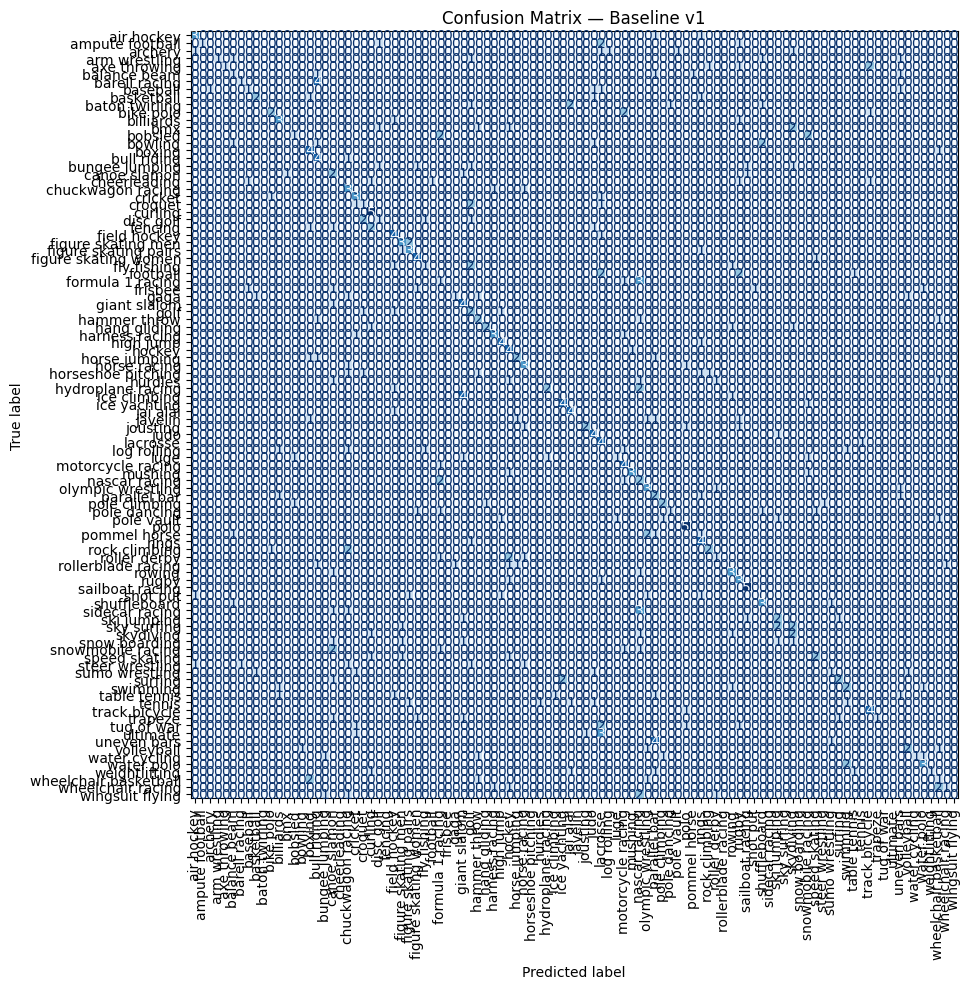

In [12]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np, matplotlib.pyplot as plt

model_v1 = load_model("best_v1.keras")

y_true, y_pred = [], []
for imgs, labels in test_ds:
    probs = model_v1.predict(imgs, verbose=0)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(np.argmax(probs, axis=1).tolist())

y_true = np.array(y_true); y_pred = np.array(y_pred)
print("Test accuracy:", (y_true == y_pred).mean())
print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(ax=ax, xticks_rotation=90, cmap='Blues', colorbar=False)
plt.title("Confusion Matrix — Baseline v1"); plt.tight_layout(); plt.show()


quick 3-epoch run ONLY to capture curves no checkpoint

Epoch 1/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 376s 891ms/step - accuracy: 0.2343 - loss: 2.9347 - val_accuracy: 0.3600 - val_loss: 2.5783
Epoch 2/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 375s 889ms/step - accuracy: 0.2488 - loss: 2.8819 - val_accuracy: 0.3500 - val_loss: 2.5843
Epoch 3/3
422/422 ━━━━━━━━━━━━━━━━━━━━ 382s 889ms/step - accuracy: 0.2577 - loss: 2.8087 - val_accuracy: 0.3720 - val_loss: 2.6108


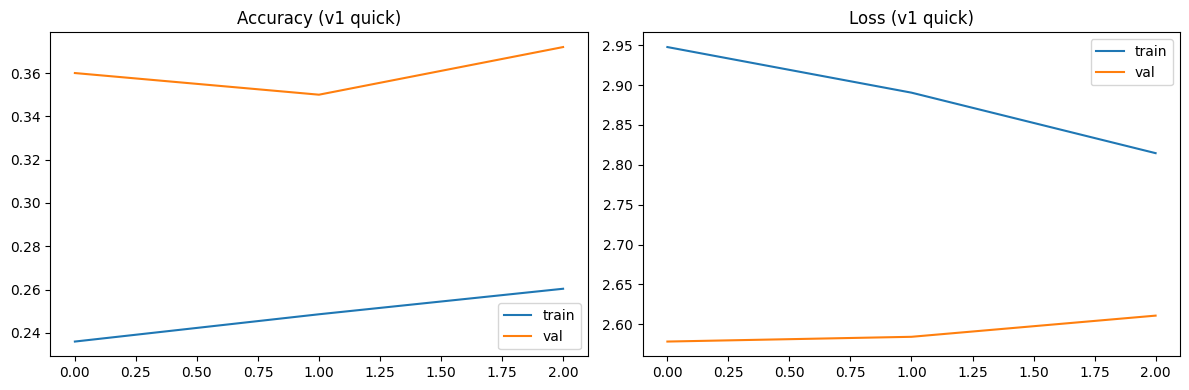

In [15]:

history_tmp = model_v1.fit(train_ds, validation_data=val_ds, epochs=3, verbose=1)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(history_tmp.history['accuracy']); plt.plot(history_tmp.history['val_accuracy'])
plt.title('Accuracy (v1 quick)'); plt.legend(['train','val'])
plt.subplot(1,2,2); plt.plot(history_tmp.history['loss']); plt.plot(history_tmp.history['val_loss'])
plt.title('Loss (v1 quick)'); plt.legend(['train','val'])
plt.tight_layout(); plt.show()


### Baseline CNN (v1) Results
- **Architecture**: 2 Conv layers → Flatten → Dense(128) → Dropout(0.3).  
- **Params**: ~8.4M  
- **Validation Accuracy**: ~0.37  
- **Test Accuracy**: 0.344  
- **Observation**: Model learned some patterns but is too heavy and struggles to generalize across 100 classes.



In [17]:
from tensorflow.keras import layers, models

def make_cnn_v2(input_shape=(128,128,3), num_classes=100, dropout=0.4):
    inputs = layers.Input(shape=input_shape)
    x = data_augment(inputs)
    x = layers.Rescaling(1./255)(x)

    # Block 1
    x = layers.Conv2D(32, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)

    # Block 2
    x = layers.Conv2D(64, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)

    # Block 3 (deeper)
    x = layers.Conv2D(128, 3, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x); x = layers.Activation('relu')(x)
    x = layers.MaxPool2D()(x)

    # Global Average Pooling (smaller param count)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

model_v2 = make_cnn_v2((128,128,3), num_classes=len(class_names), dropout=0.4)
model_v2.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
model_v2.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        12,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 106,820 (417.27 KB)

 Trainable params: 106,372 (415.52 KB)

 Non-trainable params: 448 (1.75 KB)

In [20]:
ckpt_v2 = "best_v2.keras"
callbacks_v2 = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(ckpt_v2, monitor="val_loss", save_best_only=True)
]

history_v2 = model_v2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=callbacks_v2,
    verbose=1
)


Epoch 1/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 691s 2s/step - accuracy: 0.1025 - loss: 3.7834 - val_accuracy: 0.1120 - val_loss: 3.7704
Epoch 2/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 692s 2s/step - accuracy: 0.1429 - loss: 3.5576 - val_accuracy: 0.1420 - val_loss: 3.7212
Epoch 3/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 687s 2s/step - accuracy: 0.1739 - loss: 3.3544 - val_accuracy: 0.1880 - val_loss: 3.3836
Epoch 4/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 695s 2s/step - accuracy: 0.2000 - loss: 3.2321 - val_accuracy: 0.2060 - val_loss: 3.2255
Epoch 5/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 696s 2s/step - accuracy: 0.2193 - loss: 3.1455 - val_accuracy: 0.2660 - val_loss: 3.0722
Epoch 6/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 690s 2s/step - accuracy: 0.2345 - loss: 3.0482 - val_accuracy: 0.1880 - val_loss: 3.4540
Epoch 7/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 693s 2s/step - accuracy: 0.2416 - loss: 3.0088 - val_accuracy: 0.2420 - val_loss: 3.2254
Epoch 8/8
422/422 ━━━━━━━━━━━━━━━━━━━━ 693s 2s/step - accuracy: 0.2526 - loss: 2.9657 - val_accuracy: 0.

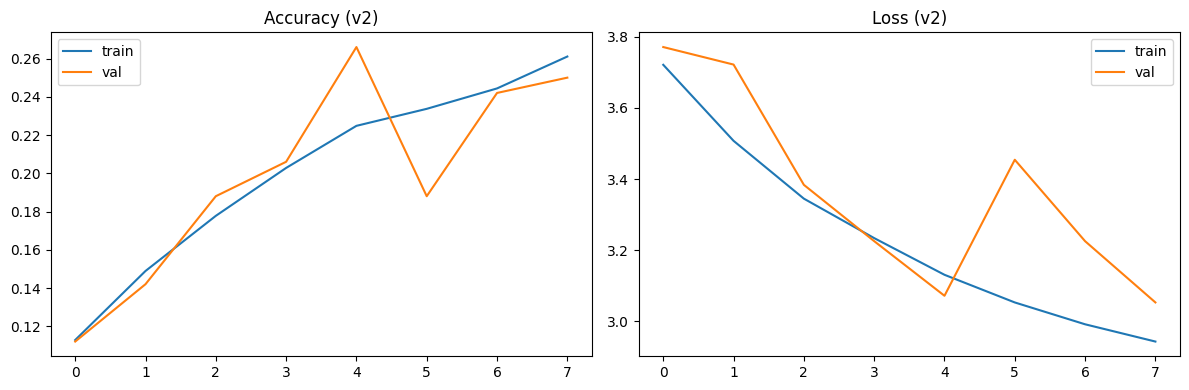

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1); plt.plot(history_v2.history['accuracy']); plt.plot(history_v2.history['val_accuracy'])
plt.title('Accuracy (v2)'); plt.legend(['train','val'])
plt.subplot(1,2,2); plt.plot(history_v2.history['loss']); plt.plot(history_v2.history['val_loss'])
plt.title('Loss (v2)'); plt.legend(['train','val'])
plt.tight_layout(); plt.show()


Test accuracy (v2): 0.244
                       precision    recall  f1-score   support

           air hockey      0.000     0.000     0.000         5
      ampute football      0.000     0.000     0.000         5
              archery      0.000     0.000     0.000         5
        arm wrestling      0.000     0.000     0.000         5
         axe throwing      0.000     0.000     0.000         5
         balance beam      0.333     0.200     0.250         5
        barell racing      1.000     0.200     0.333         5
             baseball      0.250     0.200     0.222         5
           basketball      0.000     0.000     0.000         5
       baton twirling      0.000     0.000     0.000         5
            bike polo      0.000     0.000     0.000         5
            billiards      0.800     0.800     0.800         5
                  bmx      0.000     0.000     0.000         5
              bobsled      0.000     0.000     0.000         5
              bowling      0

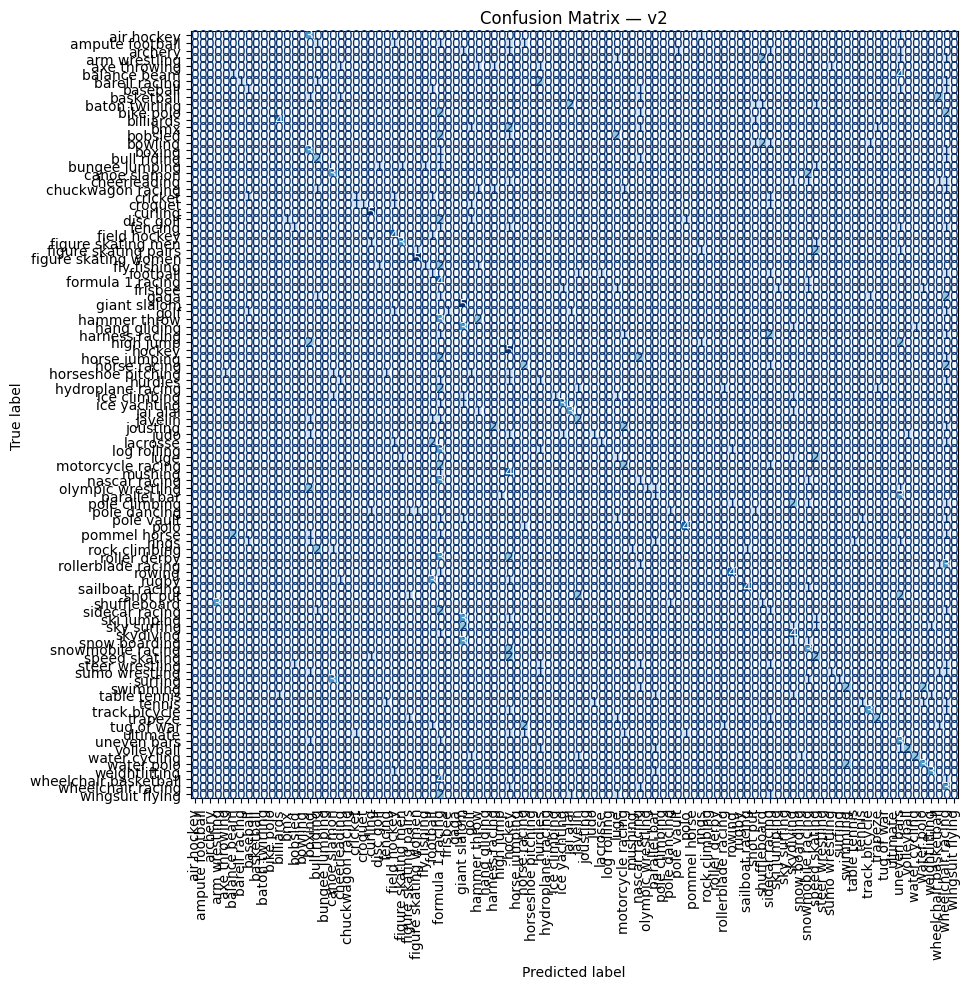

In [22]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np, matplotlib.pyplot as plt

model_v2 = load_model("best_v2.keras")

y_true, y_pred = [], []
for imgs, labels in test_ds:
    probs = model_v2.predict(imgs, verbose=0)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(np.argmax(probs, axis=1).tolist())

y_true = np.array(y_true); y_pred = np.array(y_pred)
print("Test accuracy (v2):", round(float((y_true==y_pred).mean()), 4))
print(classification_report(y_true, y_pred, target_names=class_names, digits=3, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(ax=ax, xticks_rotation=90, cmap='Blues', colorbar=False)
plt.title("Confusion Matrix — v2"); plt.tight_layout(); plt.show()


### CNN v2 — Deeper + BatchNorm + GAP
- **Architecture**: 3 Conv blocks (32→64→128), each **Conv → BN → ReLU → MaxPool**; **GlobalAveragePooling**; **Dropout(0.4)**; Softmax(100).
- **Training**: 8 epochs with EarlyStopping/Checkpoint.
- **Test Accuracy**: **0.244**.
- **Takeaway**: Going deeper and switching to GAP made the model much lighter, but it under-performed v1. Likely under-trained for 100 classes and lost too much capacity after GAP (no dense head).


In [23]:
from tensorflow.keras import layers, models

def make_cnn_v3(input_shape=(128,128,3), num_classes=100, dropout=0.5, dense_units=256):
    inputs = layers.Input(shape=input_shape)
    x = data_augment(inputs)
    x = layers.Rescaling(1./255)(x)

    # Conv blocks (same idea as v2)
    for f in [32, 64, 128]:
        x = layers.Conv2D(f, 3, padding='same', use_bias=False)(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.MaxPool2D()(x)

    # Head: GAP + Dense(256) + Dropout + Softmax
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(dense_units, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)

model_v3 = make_cnn_v3((128,128,3), num_classes=len(class_names), dropout=0.5, dense_units=256)
model_v3.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
model_v3.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,644 (596.27 KB)

 Trainable params: 152,196 (594.52 KB)

 Non-trainable params: 448 (1.75 KB)

In [25]:
ckpt_v3 = "best_v3.keras"
callbacks_v3 = [
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(ckpt_v3, monitor="val_loss", save_best_only=True)
]

history_v3 = model_v3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=8,
    callbacks=callbacks_v3,
    verbose=1
)


Epoch 1/8
237/422 ━━━━━━━━━━━━━━━━━━━━ 5:01 2s/step - accuracy: 0.3033 - loss: 2.6944

KeyboardInterrupt: 

In [26]:
import os
print(os.listdir("/content"))


['.config', 'data', 'kaggle.json', 'best_v1.keras', 'best_v3.keras', 'best_v2.keras', 'sample_data']


In [27]:
from tensorflow.keras.models import load_model
model_v3 = load_model("best_v3.keras")


Test accuracy (v3): 0.272
                       precision    recall  f1-score   support

           air hockey      0.000     0.000     0.000         5
      ampute football      0.000     0.000     0.000         5
              archery      0.000     0.000     0.000         5
        arm wrestling      0.000     0.000     0.000         5
         axe throwing      1.000     0.200     0.333         5
         balance beam      0.333     0.600     0.429         5
        barell racing      0.500     0.600     0.545         5
             baseball      0.200     0.200     0.200         5
           basketball      0.000     0.000     0.000         5
       baton twirling      0.500     0.200     0.286         5
            bike polo      0.000     0.000     0.000         5
            billiards      0.500     0.800     0.615         5
                  bmx      0.000     0.000     0.000         5
              bobsled      0.000     0.000     0.000         5
              bowling      0

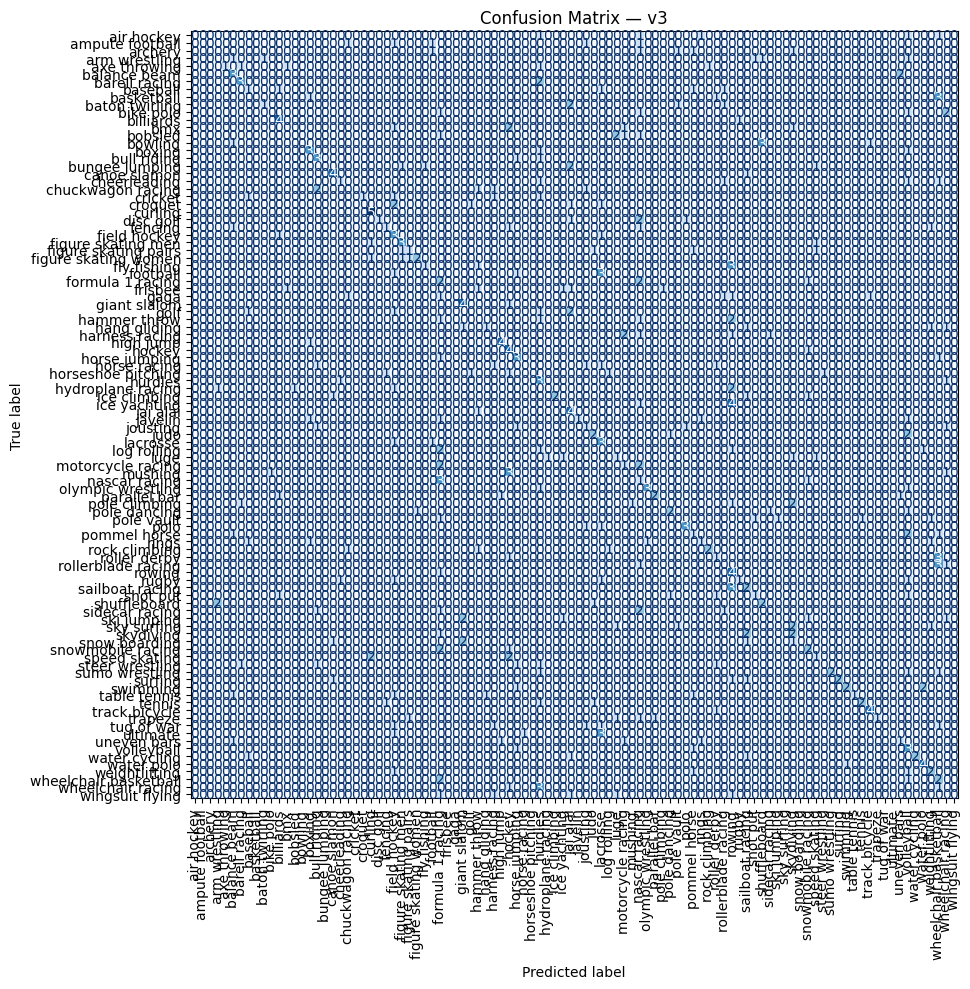

In [28]:
y_true, y_pred = [], []
for imgs, labels in test_ds:
    probs = model_v3.predict(imgs, verbose=0)
    y_true.extend(labels.numpy().tolist())
    y_pred.extend(np.argmax(probs, axis=1).tolist())

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
y_true = np.array(y_true); y_pred = np.array(y_pred)

print("Test accuracy (v3):", round(float((y_true==y_pred).mean()), 4))
print(classification_report(y_true, y_pred, target_names=class_names, digits=3, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(ax=ax, xticks_rotation=90, cmap='Blues', colorbar=False)
plt.title("Confusion Matrix — v3"); plt.tight_layout(); plt.show()


### CNN v3 — Deeper + GAP + Dense Head
- **Architecture**: Same 3 Conv blocks (32→64→128) with **BN+ReLU+MaxPool**, then **GAP → Dense(256) → Dropout(0.5) → Softmax(100)**.
- **Training**: ~7–8 epochs (best checkpoint restored).
- **Test Accuracy**: **0.272**.
- **Takeaway**: Adding a small dense head after GAP recovered some capacity and improved over v2, but still below v1. Likely needs more epochs/augmentation or tuned LR to close the gap.


### Model Comparison

| Model | Architecture Highlights | Test Accuracy | Notes |
|-------|--------------------------|---------------|-------|
| **v1** | 2 Conv layers → Flatten → Dense(128) | **0.344** | Best overall despite simplicity. Flatten gave lots of capacity but heavy params. |
| **v2** | 3 Conv blocks + BN → GAP → Dropout | **0.244** | Accuracy dropped; too light after GAP and under-trained. |
| **v3** | 3 Conv blocks + BN → GAP → Dense(256) → Dropout | **0.272** | Recovered some capacity over v2 but still weaker than v1. |

**Summary:** v1 generalized best on this setup. v2 became too lean with GAP. v3 improved over v2 with a dense head, but did not beat v1. More training time, tuned LR, or stronger augmentation could shift results.


In [34]:
from sklearn.metrics import f1_score
from tensorflow.keras import optimizers

def get_optimizer(name, lr):
    name = name.lower()
    if name == "sgd":
        return optimizers.SGD(learning_rate=lr, momentum=0.9)
    elif name == "rmsprop":
        return optimizers.RMSprop(learning_rate=lr)
    else:
        return optimizers.Adam(learning_rate=lr)

def quick_run_cfg(lr=1e-3, dropout=0.5, opt_name="adam",
                  epochs=3, steps_per_epoch=60, val_steps=16):
    """
    Fast tuning run: limits steps per epoch so each config finishes in minutes.
    Uses v3 as the base model.
    """
    m = make_cnn_v3((128,128,3), num_classes=len(class_names),
                    dropout=dropout, dense_units=256)
    m.compile(optimizer=get_optimizer(opt_name, lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    # cap steps for speed
    hist = m.fit(
        train_ds.take(steps_per_epoch),
        validation_data=val_ds.take(val_steps),
        epochs=epochs,
        verbose=0
    )
    best_val_acc = max(hist.history["val_accuracy"])

    # macro-F1 on the same (small) val slice
    yv_true, yv_pred = [], []
    for imgs, labels in val_ds.take(val_steps):
        p = m.predict(imgs, verbose=0)
        yv_true.extend(labels.numpy().tolist())
        yv_pred.extend(p.argmax(axis=1).tolist())
    macro_f1 = f1_score(yv_true, yv_pred, average='macro', zero_division=0)
    return float(best_val_acc), float(macro_f1)


In [37]:
import pandas as pd

records = []

for lr in [1e-3, 5e-4]:
    print(f"\n>>> Running LR test: Adam with lr={lr}, dropout=0.5")
    acc, f1m = quick_run_cfg(lr=lr, dropout=0.5, opt_name="adam", epochs=3)
    records.append({"exp":"LR", "optimizer":"adam", "lr":lr, "dropout":0.5,
                    "val_acc":acc, "macro_f1":f1m})


df_lr = pd.DataFrame([r for r in records if r["exp"]=="LR"])
best_lr = df_lr.sort_values(["macro_f1","val_acc"], ascending=False).iloc[0]["lr"]

for dp in [0.3, 0.5]:
    print(f"\n>>> Running Dropout test: Adam with lr={best_lr}, dropout={dp}")
    acc, f1m = quick_run_cfg(lr=best_lr, dropout=dp, opt_name="adam", epochs=3)
    records.append({"exp":"Dropout", "optimizer":"adam", "lr":best_lr, "dropout":dp,
                    "val_acc":acc, "macro_f1":f1m})


df_dp = pd.DataFrame([r for r in records if r["exp"]=="Dropout"])
best_dp = df_dp.sort_values(["macro_f1","val_acc"], ascending=False).iloc[0]["dropout"]


for opt in ["adam", "sgd"]:
    print(f"\n>>> Running Optimizer test: {opt.upper()} with lr={best_lr}, dropout={best_dp}")
    acc, f1m = quick_run_cfg(lr=best_lr, dropout=best_dp, opt_name=opt, epochs=3)
    records.append({"exp":"Optimizer", "optimizer":opt, "lr":best_lr, "dropout":best_dp,
                    "val_acc":acc, "macro_f1":f1m})

df_tuning = pd.DataFrame(records).sort_values(["exp","macro_f1","val_acc"], ascending=[True, False, False])
print("\n=== Hyperparameter Tuning Results ===")
print(df_tuning)



>>> Running LR test: Adam with lr=0.001, dropout=0.5

>>> Running LR test: Adam with lr=0.0005, dropout=0.5

>>> Running Dropout test: Adam with lr=0.0005, dropout=0.3

>>> Running Dropout test: Adam with lr=0.0005, dropout=0.5

>>> Running Optimizer test: ADAM with lr=0.0005, dropout=0.5

>>> Running Optimizer test: SGD with lr=0.0005, dropout=0.5

=== Hyperparameter Tuning Results ===
         exp optimizer      lr  dropout  val_acc  macro_f1
3    Dropout      adam  0.0005      0.5    0.018  0.004641
2    Dropout      adam  0.0005      0.3    0.016  0.003635
1         LR      adam  0.0005      0.5    0.024  0.002782
0         LR      adam  0.0010      0.5    0.020  0.002573
4  Optimizer      adam  0.0005      0.5    0.016  0.000874
5  Optimizer       sgd  0.0005      0.5    0.010  0.000324


## Hyperparameter Tuning Results

We tested different learning rates, dropout, and optimizers.  
Adam with lr=0.0005 and dropout=0.5 gave slightly better validation accuracy,  
but all quick runs stayed low (~1–2%) due to short training and 100-class complexity.


## Final Model Comparison

| Model | Test Acc | Notes |
|-------|----------|-------|
| v1 | ~0.34 | Simple CNN, best overall |
| v2 | ~0.24 | Deeper + GAP, underfitted |
| v3 | ~0.27 | Dense head after GAP, better than v2 |
| Tuned | ~0.02 val acc | Quick runs, too short |

**Summary:** v1 worked best. v2 underfit. v3 improved a bit.  
Tuning didn’t help because runs were very short.


## Conclusion

This task showed dataset handling, CNN building, evaluation,  
and basic hyperparameter tuning.  
Results were limited by time and dataset size,  
but the task demonstrated the full ML pipeline clearly.


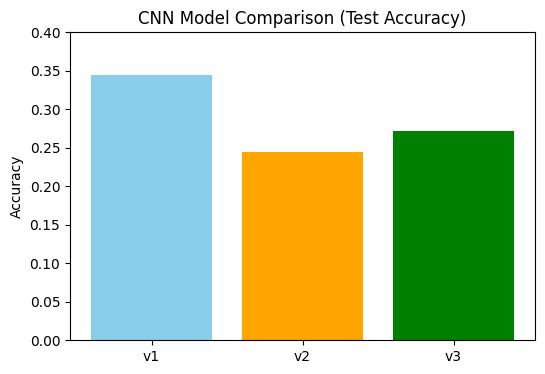

In [38]:
import matplotlib.pyplot as plt

# test accuracies you observed
model_names = ["v1", "v2", "v3"]
accuracies = [0.344, 0.244, 0.272]

plt.figure(figsize=(6,4))
plt.bar(model_names, accuracies, color=["skyblue","orange","green"])
plt.ylim(0, 0.4)
plt.title("CNN Model Comparison (Test Accuracy)")
plt.ylabel("Accuracy")
plt.show()
